# Credit Card Fraud Detection

* Anomaly detection is a type of analysis where we try to identify an abnormal activity, or an __outlier__ in a sea of normal samples. This is useful in many applications such as detecting hacking attempts on a server or a website, or detecting fraudulent credit transactions 


## Dataset and Domain knowledge 

I'm going to use an open source dataset available on Kaggle. In this dataset we have 30 parameters: The __Time__ and __Amount__ of the transaction, and 28 other features that are the result of a Principal Component Analysis (PCA) - A Dimensionality Reduction Method, in order to protect the identity of the credit card holders. This is a type of a machine learning problem that deals with binary classification. We have two labels in the __Class__ column where 1 corresponds to a fraudulent transaction, while 0 corresponds to a a valid one. 

Due to the nature of the data this set represent, there is a large class imbalance between safe and fraudulent transactions. Most of the time a person will not be subject to credit card thefts or hacking. While at some other rare days, a person's credit card gets stolen from them and that is the source of the minority class in this dataset.  

* What are the characteristics of a fraud?
* __Amount__: Most of the time the differences in transactions amounts are similar for a given person. Large, sudden __Amount__ might indicate fraud. 
* __Time__: For a given client, most safe transactions happen with a regular pattern of time specific to that client. A fraudulent transaction of a large amount has a large possibility of being a fraud. For example, of a large-amount transaction happens during the usual work time for a client, the possibility of it being a fraud is very high. 

There are several other characteristics, However, in this dataset we do not have full access to the information associated with the credit card holder. 

## Theory and Approach 
Since this is not a regular classification problem where we have similar counts of samples in each class, the evaluation metrics I'm going to use will not to include the simple __Accuracy__ metric. Instead, I'm going to rely on __Confusion Matrix__, __precision-recall__ curve and __Area Under the Curve__ to evaluate the performance of my model. 

Classifiers in Scikit-learn can produce information about the uncertainty associated with a particular prediction, using what's called __Decision Function__, like the predict_proba method. This information gives us an idea about the classifier's score per test point. In other words, How confidently the classifier predicts the __positive or negative class__. In a regular classification problem, the class with probability of more than 50% will be predicted, adjusting this threshold to a higher percentage means the classifier has top be more confident in making predictions (e.g. predict class(1) only if the estimated probability is > 70% ). This will allow us to tune the classification algorithm to be more or less conservative about making __False Positives (FP)__ or __False Negatives (FN)__ errors. 


* As a reminder, the precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

* The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

For this project, False Negatives are Fraud samples classified as valid ones. FN errors have serious and dramatic consequences, therefore we should try to reduce the False Negative errors as much as possible. This problem can be referred to as Recall-Oriented, because we want to obtain the highest possible Recall   


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline

# 1. Exploring and Visualizing the data


In [2]:
data = pd.read_csv("creditcard.csv")
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


0    284315
1       492
Name: Class, dtype: int64

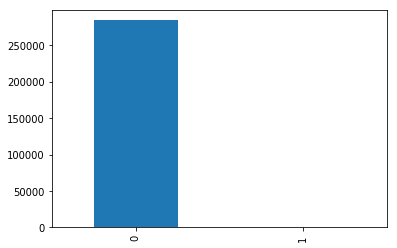

In [3]:
count = pd.value_counts(data['Class'], sort = True).sort_index()
count.plot(kind = 'bar')
count

As can be seen from the above bar plot, 284315 samples belong to the negative class, while only 492 belong to the positive class (Fraud). That's a large class imbalance that we must account for as we go on. 



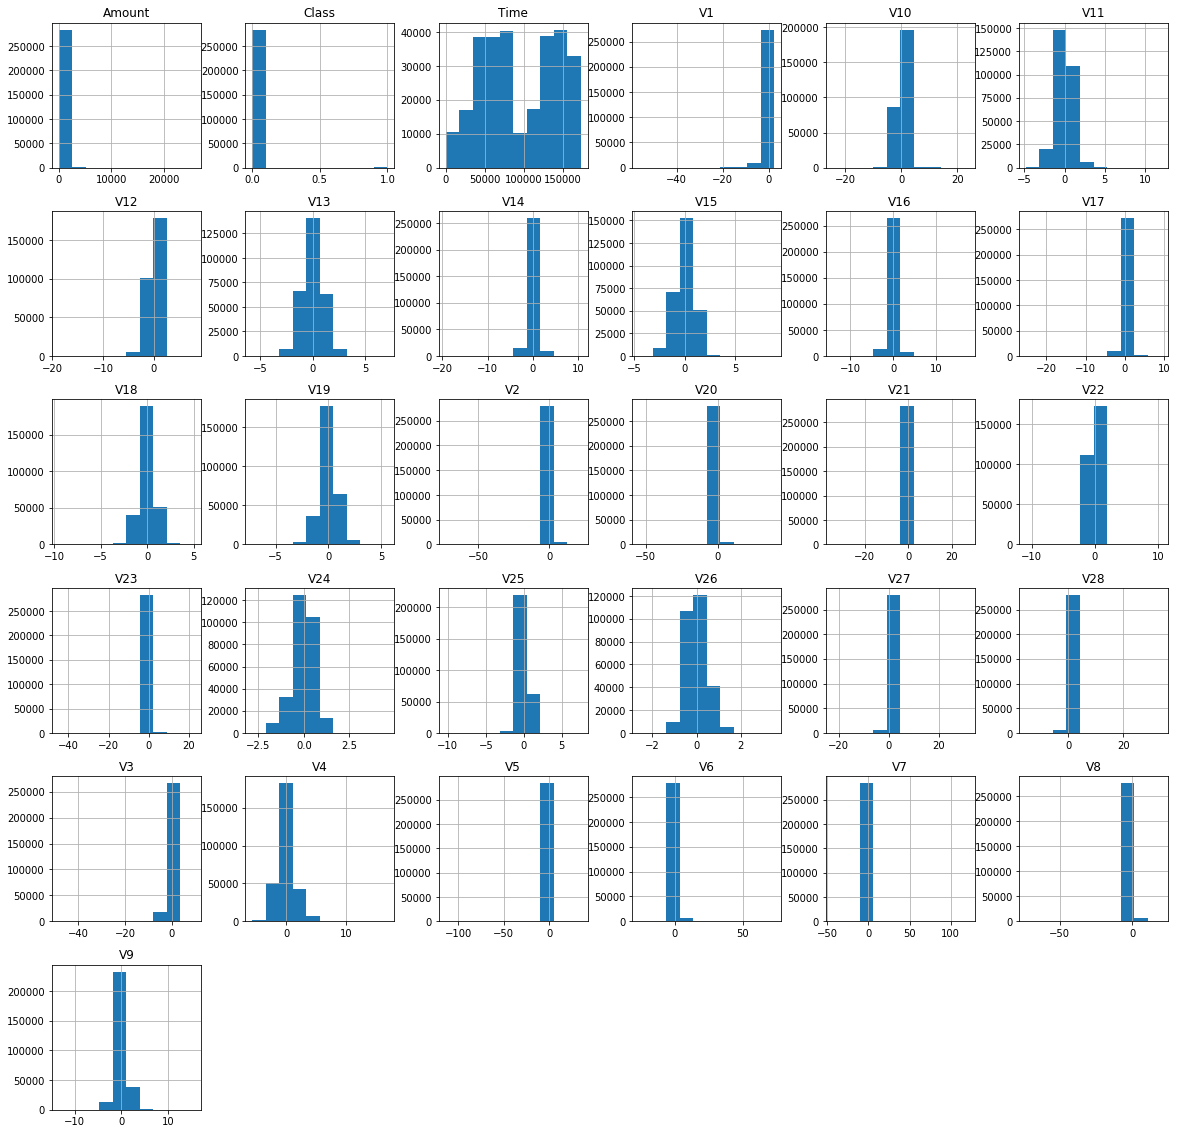

In [4]:
data.hist(figsize=(20,20))
plt.show()

Histograms also show that most feature values are clustered around 0 with fairly large outliers, or no outliers with regards to V13. Again we see the imbalance in the __Class__ histogram. 

To get an idea of which features are most important for this classification task and the kind of correlation between the features in this set, let us check the __correlation matrix__ 

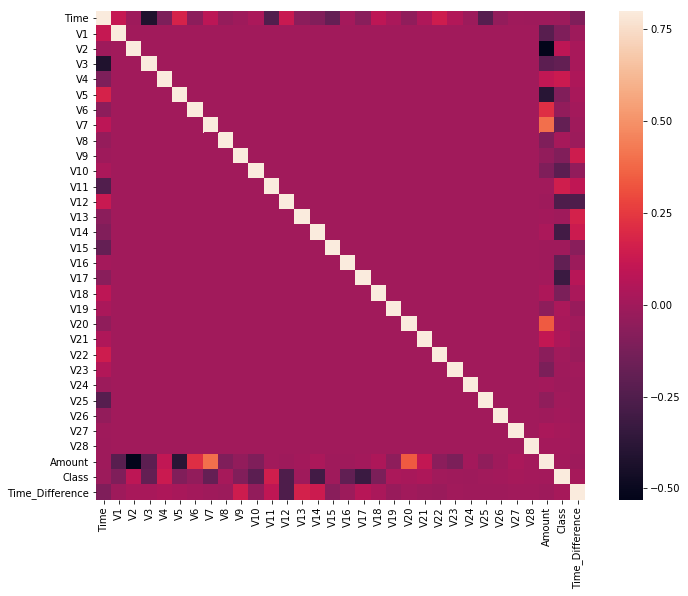

In [21]:
## Correlation matrix
Corra_Matrix = data.corr()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(Corra_Matrix, vmax=0.8, square=True)

The above is a basic correlation matrix that I did not customize to reflect exact correlation magnitudes. It is informative enough in the sense that we can see the smooth areas in the middle which indicates the fairly uncorrelated features. Looking down at the bottom however, we notice some variations in the relationships between the different features and the __Class__ or label column. For example, V17 indicates a stronger negative correlation while V11 is a stronger positive correlation. 

I don't find any features that exhibit stong enough correlation worth removing before I go on, so let us keep all the features.

# 2. Training, Validation and Holdout sets 

In [6]:
# Labels 
y = data['Class']
# Features
X = data.drop('Class',axis=1)

# Training set <> Holdout Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=8125)
# Training set <> Validation set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.333, stratify=y_train,random_state=8125)


# Why? and Where?
train = pd.concat([X_train, y_train],axis=1)
validation = pd.concat([X_validate, y_validate],axis=1)
test = pd.concat([X_test, y_test],axis=1)



# Checking if porportions are similar in the sets 
print("Percentage of fraud transactions in train is: ",round(train.Class.mean(),4))
print("Percentage of fraud transactions in test is: ",round(test.Class.mean(),4))

Percentage of fraud transactions in train is:  0.0017
Percentage of fraud transactions in test is:  0.0017


# 3. Feature Engineering
After examining all features in the above step using histograms, bar plots and correlation matrix. I became interested in exploring the two features that are not PCAs, namely the __Time__ and __Amount__ features. 
let's first see how good the __Time__ feature in seperating the two classes, and if it can use some __engineering__ to do a better job.

## 3.1 Time Feature 

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,142228.0,94894.700214,47514.517604,0.0,54262.00,84845.5,139340.25,172792.0
1,246.0,78917.178862,47120.804097,406.0,41196.25,74647.5,110550.75,170348.0


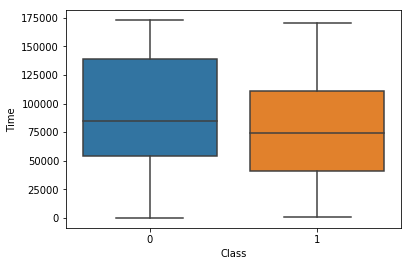

In [7]:
sns.boxplot(x="Class", y="Time",data=train)
train.groupby("Class").Time.describe()

The above __Time__ feature does not seem to separate the safe transactions from the fraud transactions well. let's create a new Feature using the time difference between two consecutive transactions 


In [8]:
data = pd.concat([train,validation,test],axis=0)
#the column names are auto reordered, lets turn it back to what it should be
data = data[list(train.columns.values)]
data.sort_index(inplace=True)
#create the time difference feature
data['Time_Difference'] = data['Time']-data['Time'].shift()
#remove the nan row caused by lag
data.dropna(axis=0,inplace=True)

#split the data set again
y = data['Class']
X = data.drop('Class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=8125)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.333, stratify=y_train,random_state=8125)
train = pd.concat([X_train, y_train],axis=1)

In [9]:
train.groupby('Class').Time_Difference.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,142227.0,0.605054,1.044713,0.0,0.0,0.0,1.0,32.0
1,246.0,1.138211,1.848663,0.0,0.0,1.0,1.0,12.0


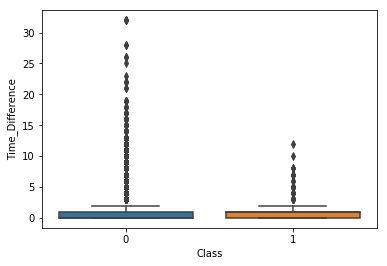

In [10]:
sns.boxplot(x="Class", y="Time_Difference",data=train)

As can be concluded from the above boxplot, time windows between most transactions are similar. A large difference will act as an outlier in this case and it will be an indicator of a fraudulent transaction. This will act as a good feature to help the model better classify the transactions so I will include it.  


## 3.2 Amount Feature 
Transactions classified as fraud have higher spending amounts, which conforms to the nature of fraudulent transactions, let's see if this is the case.  

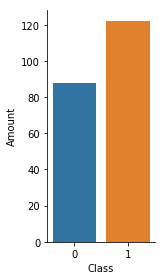

In [11]:
sns.factorplot(x="Class", y="Amount", data=train, kind="bar", ci=None, aspect=.6)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,142227.0,88.078038,250.113191,0.0,5.69,22.000,77.0000,25691.16
1,246.0,122.171829,246.790034,0.0,1.00,10.145,112.1725,2125.87


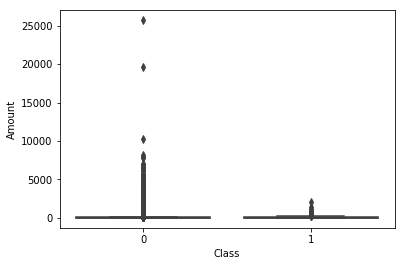

In [12]:
sns.boxplot(x="Class", y="Amount", data=train)
train.groupby('Class').Amount.describe()

from the overall patterns of response for the two group shown above, the average amount of Valid transactions is greater than the Fraudulent ones. However, transactions with large amount are mostly fraud. Even though average amount of non-fraud is greater than fraud, transaction of large amount however are mostly fraud, which also conforms to the nature of the Fraudulent transactions. let's set a cutoff amount that helps improve this feature. 





In [13]:
pd.options.mode.chained_assignment = None
def amount_threshold(x):
    if x > 2000: return 1
    else: return 0
    
X_train['Large_Amount'] = X_train['Amount'].apply(amount_threshold)
X_validate['Large_Amount'] = X_validate['Amount'].apply(amount_threshold)
X_test['Large_Amount'] = X_test['Amount'].apply(amount_threshold)

At this point I have engineered 2 new features and added them as new columns into the 3 datasets. 


now I modified time and amount to create 2 new features that are better at seperating the safe class from the fraud.   

* I added Time_Difference and Large_Amount features to the Training, Validation and Holdout dataset 
* Now our modeling will be using X_test and X_validate and we will keep X_test until the end! 

# 4. Machine Learning Models 

There are several options of classifier algorithms to choose from and compare. However, sometimes knowledge about the dataset at hand can help us filter out some options at an earlier point. For example, with a dataset like the one we are working with, a Support Vector Classifier (SVC) will consume too long to train a model on this dataset, as SVCs are known for their poor handling of large datasets. 
After narrowing down several options, I decided to compare the performance of the following two classifiers:
* Logistic regression
* Random Forest

## 4.1 Logistic Regression with Cross-Validation
A useful class found in sklearn is the Logistic Regression with Cross-Validation. I will use is instead of the regular Logistic Regression Class to find an optimal value to tune the regularization parameter C. 

In [29]:
logCV = LogisticRegressionCV(Cs=[0.01,0.1,1,10,100], scoring='average_precision', verbose=0,
                             max_iter=500, cv=5, random_state=5001)
logCV.fit(X_train,y_train)
print("The best parameter C is",logCV.C_[0])

C:\Users\AdamO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\AdamO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The best parameter C is 10.0


An associated method with this class of logistic regression is C_, which is an array of regulariziation parameters that maps to the best scores across every class. C_ is of shape(n_classes,) when the problem is binary as in this case. The best score can be found at the first location of this array C_[0] and it is returned the value of 10. 
We  now use the fitted model to predict our validation set.


## 4.2 Evaluating the model on the Validation set
There are several other useful functions for analyzing the results from the probability estimates associated with the Logistic Regression algorithm in sklearn. 
The __predict_proba__ is another one which returns a set of probability estimates, which I will analyze with respect to a Precision-Recall Curve. 
__average_precision_score__ takes (y_true, y_score) and computes average precision (AP) from prediction scores. The __precision_recall_curve__ method computes Precision-Recall pairs for different probability thresholds, it takes the predicted labels and the true labels we have in our validation set. 


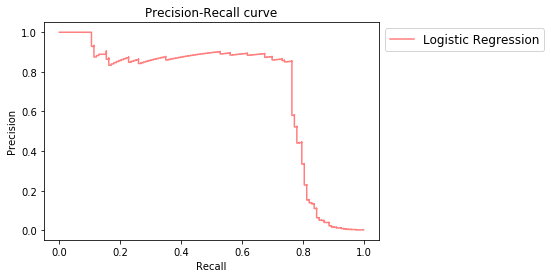

In [39]:
pred_prob = logCV.predict_proba(X_validate)
y_score = pred_prob[:,1]
average_precision = average_precision_score(y_validate, y_score)
original_precision, original_recall, original_thresholds = precision_recall_curve(y_validate, y_score)

# PLOT P-R curve
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

From the PR curve above we can see how our model performed, and we can choose optimised cutoff to yield the precision and recall rate we want.



In [47]:
print(classification_report(y_validate, logCV.predict(X_validate)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71008
           1       0.89      0.65      0.75       123

   micro avg       1.00      1.00      1.00     71131
   macro avg       0.94      0.83      0.88     71131
weighted avg       1.00      1.00      1.00     71131



In [42]:
conf = confusion_matrix(y_validate,logCV.predict(X_validate))
conf

array([[70998,    10],
       [   43,    80]], dtype=int64)

### Evaluation Observations

Now we can make few observations from the P-R curve, Classification report and Confusion matrix we produced for the logistic regression model we fitted:
* In the P-R curve, the optimal point for our task is located at the Top-Right corner of the curve, where we have more Recall and less Precision. This is because we want to __minimize False Negatives__, which in this case are the Fraud samples classified as Valid ones. Minimizing FNs will naturally Maximize the Recall, and this is our goal. 
* at this point we have a Recall of 0.65 and Precision of 0.89. Keep in mind that reduced one of them will increase the other and Vice Versa
* The Confusion Matrix shows that we have 43 Fraud samples classified as Valid ones, which in the real world is a big problem. 
* In the next steps, I will try and improve this result through Resampling, as well as trying a different model. 

# 5. Data Resampling
One of the documented methods of improving performance in the case of unbalanced datasets that can be found in the literature [1], is over-sampling. In this process, we basically match  the number of class 0 sample to class 1 samples. Synthetic Minority Over-sampling Technique (SMOTE) and Random Over-Sampling Examples (ROSE) are typically used to do this task and there are few differences between them. ROSE uses smoothed bootstrapping to draw artificial samples from the feature space neighborhood around the minority class. On the other hand, SMOTE draws artificial samples by choosing points that lie on the line connecting the minority observation to one of its nearest neighbors in the feature space.

I previously used both methods to treated imbalanced data, and found SMOTE to produce better outcomes. I believe the reason is that SMOTE creates more realistic values than ROSE. ROSE produced values that were impossible such as negative area sizes or elevation. 

* One important thing to mention is that we should not re-sample our validation or test set, since it might lead to a prediction that is over-optimistic and does not reflect the true performance of the model. 



In [48]:
sm = SMOTE(random_state=1, kind='regular')
X_resampled, y_resampled = sm.fit_sample(X_train,y_train)
pd.value_counts(y_resampled)

1    142227
0    142227
dtype: int64

## 5.1 Evaluating the Re-sampled set 

Now lets evaluate the Logistic Regression model with the same parameters to see if the performance has improved

In [50]:
log_res = LogisticRegression(C=10, verbose=0, random_state=3)
log_res.fit(X_resampled, y_resampled)

C:\Users\AdamO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=3, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

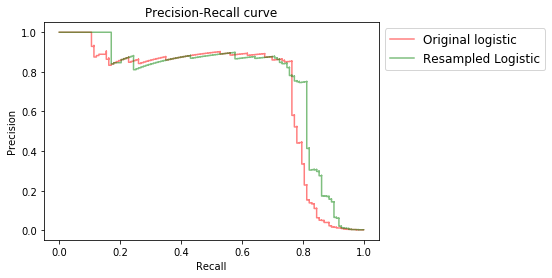

In [51]:
pred_prob = log_res.predict_proba(X_validate)
resampled_score = pred_prob[:,1]
average_precision = average_precision_score(y_validate, y_score)
resampled_precision, resampled_recall, resampled_thresholds = precision_recall_curve(y_validate, resampled_score)
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Original logistic')
plt.step(resampled_recall, resampled_precision, color='green', alpha=0.5,linewidth=1.5,label='Resampled Logistic')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

In [52]:
print(classification_report(y_validate, log_res.predict(X_validate)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71008
           1       0.09      0.90      0.17       123

   micro avg       0.98      0.98      0.98     71131
   macro avg       0.55      0.94      0.58     71131
weighted avg       1.00      0.98      0.99     71131



In [54]:
conf = confusion_matrix(y_validate,log_res.predict(X_validate))
conf

array([[69938,  1070],
       [   12,   111]], dtype=int64)

### Evaluation Observations
The number of __True Positives__ has increased from 80 to 111, and the number of __False Negatives__ has decreased from 43 to 12. This is an excellent improvement, the classifier detects more of the Fraud samples and the __Recall__ has increased from 0.65 to 0.9. 
This is also reflected in a decrease in Precision as one might expect. We can see in the Confusion matrix that the number of False Positives, has also jumped significantly. In Real-World applications we can think of this as if the classifier errors to be more on the safe side. This is again, because the consequences of predicting a fraud transaction as a valid one, is way more serious than __erroring__ as a safety measure.  

From the P-R curve, we can see that more area is covered by the re-sampled curve than the previous model, and we got closer to the optimal point. 

# 6. Random Forest Model 

Random Forest fall under the category of ensemble methods, meaning that they use a number of weak classifiers to produce a strong classifier, which usually means better results. In this case, the decision trees are the weak classifiers. Decision trees basically work by splitting the data up by its features and classifying data using splits. Combine a bunch of these decision trees, we get a Random Forest. Each individual tree will be different. Thus, a Random Forest will combine the prediction of each tree and vote- the highest voted prediction will emerge as the final prediction.




In [57]:
rf = RandomForestClassifier(max_depth=4, n_estimators=100, bootstrap=True, random_state=7017)
rf.fit(X_resampled,y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=7017, verbose=0,
            warm_start=False)

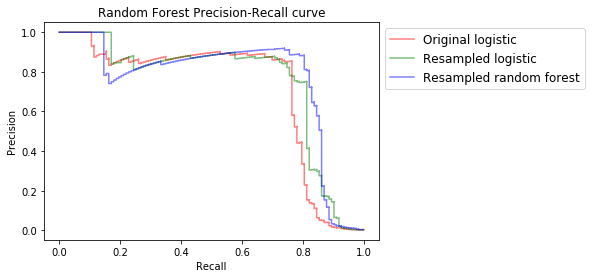

In [58]:
pred_prob = rf.predict_proba(X_validate)
rf_score = pred_prob[:,1]
average_precision = average_precision_score(y_validate, y_score)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_validate, rf_score)
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Original logistic')
plt.step(resampled_recall, resampled_precision, color='green', alpha=0.5,linewidth=1.5,label='Resampled logistic')
plt.step(rf_recall, rf_precision, color='blue', alpha=0.5,linewidth=1.5,label='Resampled random forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall curve')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

In [59]:
print(classification_report(y_validate, rf.predict(X_validate)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71008
           1       0.21      0.87      0.34       123

   micro avg       0.99      0.99      0.99     71131
   macro avg       0.60      0.93      0.67     71131
weighted avg       1.00      0.99      1.00     71131



In [60]:
conf = confusion_matrix(y_validate,rf.predict(X_validate))
conf

array([[70600,   408],
       [   16,   107]], dtype=int64)

### Evaluation Observations
The Random Forest Model produces similar results to the Logistic Regression Model, the results from the above report, matrix and P-R curve are interesting to analyze. 
We can see that the Recall for the Fraud samples has dropped slightly from 0.9 to 0.87, and as expected the Precision has jumped slightly. The number of Fraud transactions correctly identified has decreased from 111 to 107, __But__ the number of misclassified Valid cases has dropped significantly from 1070 to 408! This is less annoying to the client, as the real-world system will not error as a safety measure as much as the previous model. As a result, Precision jumped from 0.093 to 0.021. This can be seen as a good balance for a classifier that is excellent as predicting the Fraud cases, as well as the valid cases. 

## 7. Optimize Selected Model
At this point, the goal is to find the optimal threshold for the chosen Random Forest classifier. 

In [61]:
error = []
for recall, precision in zip(rf_recall, rf_precision):
    err = (recall-0.81)**2 + (precision-0.84)**2
    error.append(err)
error = np.asarray(error)
min_index = np.where(error==min(error))
opt_threshold = rf_thresholds[min_index]
"The optimised threshold is: {0:0.3f}".format(opt_threshold[0])

'The optimised threshold is: 0.820'

We obtained an optimal threshold of 82%. This means we should instruct the classifier to yield 1 (fraud) only if its 82% confident that it is fraud. let's use this rule and check the Confusion Matrix on our validation set before moving to the final evaluation on the holdout set. 

Text(0.5,1,'Confusion matrix for validation set')

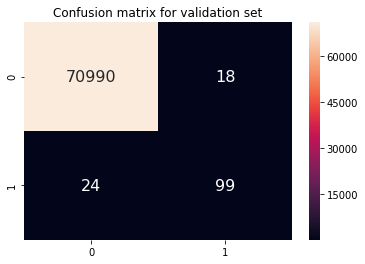

In [62]:
y_pred = [1 if x > opt_threshold else 0 for x in rf_score]
conf = confusion_matrix(y_validate,y_pred)
conf = pd.DataFrame(conf, range(2),range(2))
sns.heatmap(conf, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion matrix for validation set')

From the Confusion Matrix for the Validation set, we can quickly find the __Recall__ to be 0.8 and __Percision__ is 0.84. 
We can see a good balance between the two, as this is a classical trade off and we don't want the system to be overly strict and make too many false alarams. 

## 8. Final Evaluation on the Holdout set


Text(0.5,1,'Confusion matrix for prediction on test set')

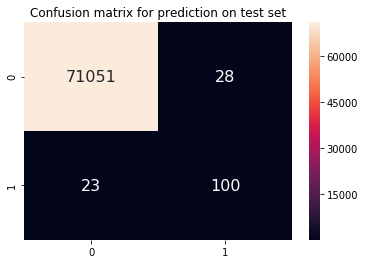

In [63]:
pred_prob = rf.predict_proba(X_test)
y_score = pred_prob[:,1]
y_pred = [1 if x > opt_threshold else 0 for x in y_score]
conf = confusion_matrix(y_test,y_pred)
conf = pd.DataFrame(conf, range(2),range(2))
sns.heatmap(conf, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion matrix for prediction on test set')

The optimized model, coupled with the optimal threshold found, yields a __Recall__ 0.81 of and Percision of 0.78. These are similar results to the ones obtained from the validation set.  

## Conclusion
In this work, I investigated Credit Card Transactions datasets that contains 30 features. I began by Exploring and Visualizing the dataset. Secondly, I created improved versions of the Time and Amount features; the two new features are more capable of separating the two classes. Thirdly, I split the dataset into Train, Validation, to ensure reliable evaluation of the performance. Fourthly, I trained a Logistic Regression Model with Cross Validation and found an optimal value for the regularization parameter C. Then I performed re-sampling using SMOTE to create a more balanced dataset to improve the results o LR. Then I moved to another Model which is Random Forest that yielded a more balanced results. Finally, I optimized the threshold of the Random Forest Classifier and produced the final results. 

Throughout this work, special care was given to the fact that this is a Recall-oriented Machine Learning Task, and so minimizing the number of False Negatives is a priority due to the serious consequences in the real-worlds applications. 

## References 

* https://www.openstarts.units.it/bitstream/10077/4002/1/Menardi%20Torelli%20DEAMS%20WPS2.pdf
* https://towardsdatascience.com/a-brief-journey-on-precision-and-recall-a2651ba99ac6

